# Mollie payment fraud detection case

# Business Case 

We are given a dataset consisting of customer payment transactions. The goal of the assignment is to build a fraud prediction model. There is one csv file that was provided.


## Contents  

This notebook contains the following sections:  

1. Imports & function definitions  
2. EDA  
3. Feature engineering  
4. Modeling  
5. Results  


The table below show my interpretation of the data.  


## Data Dictionary
The dataset has fourteen features (columns) with the following definitions and data types:

| Variable     | Data type    | Definition     |
|------|-----|-----|
| `transaction_id`    | int64     | a unique transaction identifier     |
| `batch`    | int64     | representing batch of transaction     |
| `chck_date`    | datetime     | assumed to be transaction date   |
| `customer`    | string    | a unique customer identifier    |
| `payment_type`    | string     | a unique payment_type identifier     |
| `gender`    | string     | customer gender     |
| `name`    | string     | customer name    |
| `phone`    | string     | customer phone number     |
| `cust_acc`    | string     | customer account number    |
| `merchant`    | string     | a unique merchant identifer     |
| `category`    | string     | purchase category     |
| `amount`    | float64     | transaction amount     |
| `fraud`    | int64     | target variable indicating fraud |    

## Imports & function definitions  

**Import libraries**

In [48]:
# General
import pandas as pd
import numpy as np
import math
import joblib
import pickle
import datetime
import random

#import sklearn
import sklearn
from sklearn import *
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

# for class imbalance
from imblearn.over_sampling import SMOTE

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid', {'axes.facecolor': '0.9'})
plt.rcParams['figure.figsize'] = [12, 8]

import graphviz

import warnings
warnings.filterwarnings('ignore')

**Function definitions**

In [2]:
def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.1f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.1f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

In [3]:
# function to count missing values in dataframe
def count_missings(df):
    total = df.isnull().sum().sort_values(ascending = False)
    percent = (df.isnull().sum() / df.isnull().count() * 100).sort_values(ascending = False)
    table = pd.concat([total, percent], axis = 1, keys = ["Total", "Percent"])
    table = table[table["Total"] > 0]
    return table

In [4]:
# function to classify datetime to weekday/weekend
def is_weekend(transaction_date):
    """computes if date is weekend
    Args:
       datetime variable 
    Returns:
       boolean: is_weekend 
    """
    # transform date into weekday (0 is Monday, 6 is Sunday)
    weekday = transaction_date.weekday()
    # binary value: 0 if weekday, 1 if weekend
    is_weekend = weekday>=5
    
    return int(is_weekend)

In [5]:
# function to classify datetime to day/night
def is_night(transaction_date):
    """computes if time is at night
       defines as between 00:00 and 06:00
    Args:
       datetime variable
    Returns:
       boolean: is_night
    """
    # Get the hour of the transaction
    tx_hour = transaction_date.hour
    # Binary value: 1 if hour less than 6, and 0 otherwise
    is_night = tx_hour<=6
    
    return int(is_night)

In [6]:
def get_customer_rfm_features(customer_transactions, windows_size_in_days=[1,7,30]):
    """computes avg number of transactions
       and avg transactions amount for given window
    Args:
       df: dataframe with customer transactions
    Returns:
       df: dataframe with computed avg and num transactions
    """
    # let us first order transactions chronologically
    customer_transactions=customer_transactions.sort_values('chck_date')
    
    # transaction date and time is set as the index, which will allow the use of the rolling function 
    customer_transactions.index=customer_transactions.chck_date
    
    # lloping through each each window size
    for window_size in windows_size_in_days:
        
        # compute the sum of the transaction amounts and the number of transactions for the given window size
        sum_amount_transaction_window=customer_transactions['amount'].rolling(str(window_size)+'d').sum()
        num_transaction_window=customer_transactions['amount'].rolling(str(window_size)+'d').count()
    
        # compute the average transaction amount for the given window size
        # num_transaction_window is always >0 since current transaction is always included
        avg_amount_transaction_window=sum_amount_transaction_window/num_transaction_window
    
        # save feature values in list and add to df
        customer_transactions['customer_nb_tx'+str(window_size)+'day_window']=list(num_transaction_window)
        customer_transactions['customer_avg_amount_'+str(window_size)+'day_window']=list(avg_amount_transaction_window)
    
    # teindex according to transaction IDs
    customer_transactions.index=customer_transactions.transaction_id
        
    # return the dataframe with the new features
    return customer_transactions

In [7]:
def get_count_risk_rolling_window(terminal_transactions, delay_period=7, windows_size_in_days=[1,7, 30], feature="merchant"):
    """computes a rick score for each merchant
       based on historical fraudulent transactions
    Args:
       df: dataframe with customer transactions
    Returns:
       computed risk score
    """
    terminal_transactions=terminal_transactions.sort_values('chck_date')
    
    terminal_transactions.index=terminal_transactions.chck_date
    
    num_fraud_delay=terminal_transactions['fraud'].rolling(str(delay_period)+'d').sum()
    num_transaction_delay=terminal_transactions['fraud'].rolling(str(delay_period)+'d').count()
    
    for window_size in windows_size_in_days:
    
        num_fraud_delay_window=terminal_transactions['fraud'].rolling(str(delay_period+window_size)+'d').sum()
        num_transaction_delay_window=terminal_transactions['fraud'].rolling(str(delay_period+window_size)+'d').count()
    
        num_fraud_window=num_fraud_delay_window-num_fraud_delay
        num_transaction_window=num_transaction_delay_window-num_transaction_delay
    
        risk_window=num_fraud_window/num_transaction_window
        
        terminal_transactions[feature+'_num_transactions_'+str(window_size)+'day_window']=list(num_transaction_window)
        terminal_transactions[feature+'_risk_'+str(window_size)+'day_window']=list(risk_window)
        
    terminal_transactions.index=terminal_transactions.transaction_id
    
    # replace NA values with 0 (all undefined risk scores where num_transaction_window is 0) 
    terminal_transactions.fillna(0,inplace=True)
    
    return terminal_transactions

In [8]:
def transform_cat_feats(df):
    """makes null columns into unknown and cat columns
    are label encoded
    Args:
    df (pd.DataFrame): Dataframe with the transaction data.
    Returns:
    Dataframe with numerically encoded data for cat cols
    """

    cat = [
        "payment_type",
        "gender",
        "country",
        "category",]
        
        #"batch"    ]

    for feature in cat:
        encoder = LabelEncoder()
        df[feature] = encoder.fit_transform(df[feature])
        feat_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
    

    return df

## EDA

In [17]:
dtype={'Unnamed: 0':'int64', 'batch':'int64', 'customer': 'string', \
'payment_type':'string', 'gender':'string', 'name': 'string', 'phone' : 'string', 'cust_acc':'string', \
'merchant':'string', 'category':'string', 'amount':'float64', 'fraud':'int64'}
parse_dates = ['chck_date']

In [18]:
# Let's read the csv into a pandas dataframe
data = pd.read_csv("../data/mollie_fraud_dataset.csv", sep=";", dtype=dtype, parse_dates=parse_dates)
data.rename({'Unnamed: 0':'transaction_id'}, axis=1, inplace=True)
data.head()

,transaction_id,batch,chck_date,customer,payment_type,gender,name,phone,cust_acc,merchant,category,amount,fraud
0,470747,155,NaT,8448534585',1',M',Mrs. Maria Gregory,(0115)4960290,GB03WYJA75657527300725,651065399',transit',20.11,0
1,412821,59,NaT,8682289866',3',M',Mrs. Tina Sharpe,+33 1 17 64 48 43,NL78FPVF2407569857,651065399',transit',30.80,0
2,511083,86,NaT,8192432211',4',M',Daan de Wit,02 82 29 37 03,NL58TXTE4754780700,8176927312',transit',22.63,0
3,252747,172,2019-03-10 02:22:00,8577606384',2',M',Honoré du Gomez,(0161)4960724,FR8832716770788351826539286,8176927312',transit',13.93,0
4,452788,17,NaT,702254802',4',F',Adrien-Benoît Clement,+31902 210334,<NA>,790152891',personal_wellbeing',18.07,0


Let's check the dataframe for null values

In [19]:
null_table = count_missings(data)
null_table

,Total,Percent
chck_date,114572,24.084219
cust_acc,66495,13.977936


In [20]:
data.dtypes

transaction_id             int64
batch                      int64
chck_date         datetime64[ns]
customer                  string
payment_type              string
gender                    string
name                      string
phone                     string
cust_acc                  string
merchant                  string
category                  string
amount                   float64
fraud                      int64
dtype: object

There are some extra characters in some of the columns which we need to remove. 

In [21]:
strcol_list = ['customer', 'payment_type', 'gender', 'merchant', 'category']
for col in strcol_list:
    data[col] = data[col].apply(lambda x: x[:-1])

In [22]:
data.head()

,transaction_id,batch,chck_date,customer,payment_type,gender,name,phone,cust_acc,merchant,category,amount,fraud
0,470747,155,NaT,8448534585,1,M,Mrs. Maria Gregory,(0115)4960290,GB03WYJA75657527300725,651065399,transit,20.11,0
1,412821,59,NaT,8682289866,3,M,Mrs. Tina Sharpe,+33 1 17 64 48 43,NL78FPVF2407569857,651065399,transit,30.80,0
2,511083,86,NaT,8192432211,4,M,Daan de Wit,02 82 29 37 03,NL58TXTE4754780700,8176927312,transit,22.63,0
3,252747,172,2019-03-10 02:22:00,8577606384,2,M,Honoré du Gomez,(0161)4960724,FR8832716770788351826539286,8176927312,transit,13.93,0
4,452788,17,NaT,702254802,4,F,Adrien-Benoît Clement,+31902 210334,<NA>,790152891,personal_wellbeing,18.07,0


In [23]:
# fill null value for account type with previously known account type of customer
data["cust_acc"] = data.groupby(['customer'])['cust_acc'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty    
                                                                                                             else "Empty"))

We will drop the name and phone columns with the assumption that they do not provide any additional information than already available in the customer identifier. Also, from the cust_acc column we can extract the country using the first 2 characters and drop the columns.

In [24]:
# create country variable and drop unnecessary columns
data['country'] = data['cust_acc'].apply(lambda x: x[0:2])
data.drop(['name', 'phone', 'cust_acc'], axis=1, inplace=True)
data.shape

(475714, 11)

For exploratory analysis, we can use the data which has the date column filled in. Let's create a separate dataframe for it.

In [25]:
#data_df = data.loc[data['chck_date'].notna()]
#df_explore = data_df.copy()
df_explore = data.loc[data['chck_date'].notna()]
target = df_explore['amount']
mean = target.mean()
sd = target.std()
selected_df = df_explore[(target > mean - 3*sd) & (target < mean + 3*sd)]

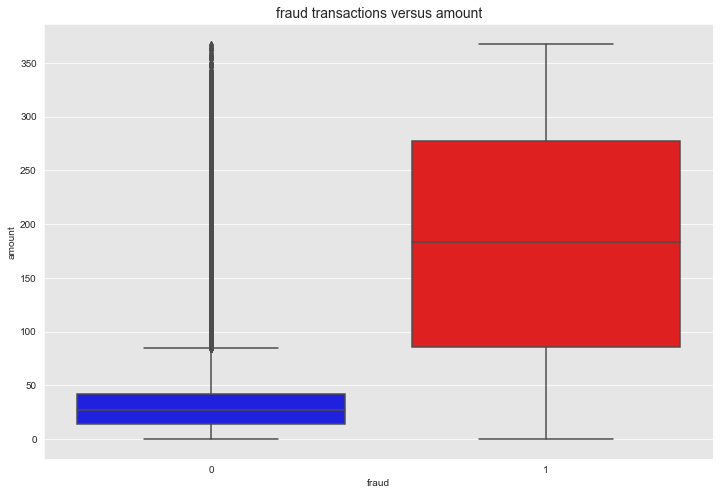

In [26]:
### amount box plot
ax = sns.boxplot(y='amount', x='fraud',  palette=['b', 'r'], data=selected_df)
ax.set_title("fraud transactions versus amount", fontsize=14)

# sets the figure size in inches
ax.figure.set_size_inches(12, 8)

# adjusts the width spaces between plots
plt.subplots_adjust(wspace = 0.4)

After removing outliers we can see that the median value of fraud transactions is higher than non-fraud transactions. Let's look at fraud vs payment_type, country and category.

In [27]:
df_agg_country = df_explore.groupby(
   ['country']
).agg({   
         'transaction_id' : 'count',
         'fraud' : 'sum'    
}).reset_index()
df_agg_country.rename(columns={'transaction_id' : 'num_transactions'}, inplace=True)
df_agg_country['fraud_percentage'] = df_agg_country['fraud']*100.0/ df_agg_country['num_transactions']
df_agg_country.sort_values(by='fraud_percentage', inplace=True)
df_agg_country.head()

,country,num_transactions,fraud,fraud_percentage
3,NL,89983,934,1.037974
0,DE,94289,1100,1.166626
1,FR,89485,1108,1.238196
2,GB,87385,1272,1.455627


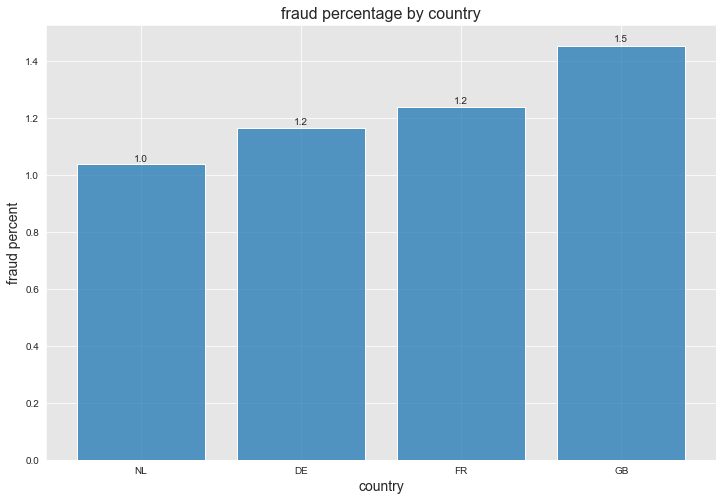

In [28]:
# plots fraud percentage by country;
ax = sns.histplot(
    df_agg_country,
    x='country',
    weights='fraud_percentage',
    shrink=0.8
)

# sets the figure size in inches
ax.figure.set_size_inches(12, 8)

# set plot features
ax.set_title("fraud percentage by country", fontsize=16)
ax.set_ylabel("fraud percent", fontsize=14)
ax.set_xlabel("country", fontsize=14)

# displays plot
show_values(ax)

GB has a slightly larger percentage of fraud transactions but it does not seem like fraud rates change much per country.

In [93]:
df_agg_payment = df_explore.groupby(
   ['payment_type']
).agg({   
         'transaction_id' : 'count',
         'fraud' : 'sum'    
}).reset_index()
df_agg_payment.rename(columns={'transaction_id' : 'num_transactions'}, inplace=True)
df_agg_payment['fraud_percentage'] = df_agg_payment['fraud']*100.0/ df_agg_payment['fraud'].sum()
df_agg_payment.sort_values(by='fraud_percentage', inplace=True)
df_agg_payment = df_agg_payment.loc[(df_agg_payment['payment_type'] != 'U') & (df_agg_payment['payment_type'] != '0')]
df_agg_payment.head()

,payment_type,num_transactions,fraud,fraud_percentage
6,6,16196,164,3.715451
1,1,35420,409,9.265972
5,5,38160,417,9.447213
4,4,66527,879,19.913910
3,3,89189,1077,24.399638


In [94]:
df_agg_payment['wt'] = df_agg_payment['num_transactions']/df_agg_payment['num_transactions'].sum()
df_agg_payment['wt_fraud'] = df_agg_payment['wt']*df_agg_payment['fraud']
df_agg_payment['weighted_fraud_contribution'] = df_agg_payment['wt_fraud']*100.0/df_agg_payment['wt_fraud'].sum()
df_agg_payment

,payment_type,num_transactions,fraud,fraud_percentage,wt,wt_fraud,weighted_fraud_contribution
6,6,16196,164,3.715451,0.045120,7.399637,0.757274
1,1,35420,409,9.265972,0.098675,40.358094,4.130222
5,5,38160,417,9.447213,0.106308,44.330559,4.536761
4,4,66527,879,19.913910,0.185335,162.909195,16.672024
3,3,89189,1077,24.399638,0.248468,267.599798,27.385993
2,2,113464,1438,32.578160,0.316094,454.543822,46.517726


In [99]:
mean_payment = df_agg_payment.weighted_fraud_contribution.mean()

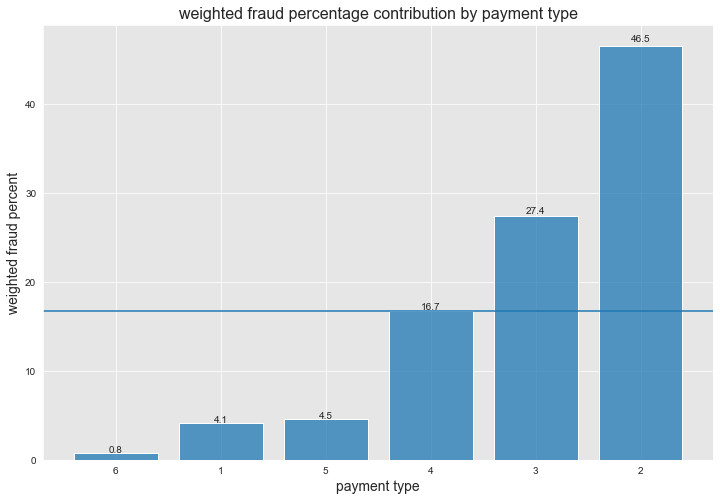

In [100]:
# plots fraud percentage by payment type;
ax = sns.histplot(
    df_agg_payment,
    x='payment_type',
    weights='weighted_fraud_contribution',
    shrink=0.8
)

ax.axhline(mean_payments)
# sets the figure size in inches
ax.figure.set_size_inches(12, 8)

# set plot features
ax.set_title("weighted fraud percentage contribution by payment type", fontsize=16)
ax.set_ylabel("weighted fraud percent", fontsize=14)
ax.set_xlabel("payment type", fontsize=14)

# displays plot
show_values(ax)

Payment type 2 (maybe credit card) has the largest percentage of fraud.

In [109]:
df_agg_category = df_explore.groupby(
   ['category']
).agg({   
         'transaction_id' : 'count',
         'fraud' : 'sum'    
}).reset_index()
df_agg_category.rename(columns={'transaction_id' : 'num_transactions'}, inplace=True)
df_agg_category['fraud_percentage'] = df_agg_category['fraud']*100.0/ df_agg_country['num_transactions']
df_agg_category.sort_values(by='fraud_percentage', inplace=True)
df_agg_category.head()
df_agg_category = df_agg_category.loc[df_agg_category['category'].isin(['clothes', 'accommodation', 'horeca'])]

In [110]:
df_agg_category['wt'] = df_agg_category['num_transactions']/df_agg_category['num_transactions'].sum()
df_agg_category['wt_fraud'] = df_agg_category['wt']*df_agg_category['fraud']
df_agg_category['weighted_fraud_contribution'] = df_agg_category['wt_fraud']*100.0/df_agg_category['wt_fraud'].sum()
df_agg_category

,category,num_transactions,fraud,fraud_percentage,wt,wt_fraud,weighted_fraud_contribution
1,clothes,3968,67,0.074873,0.442117,29.621838,28.703642
3,horeca,3924,75,0.083349,0.437214,32.791086,31.774652
0,accommodation,1083,338,0.358472,0.120669,40.785961,39.521707


In [111]:
mean_category = df_agg_category.weighted_fraud_contribution.mean()

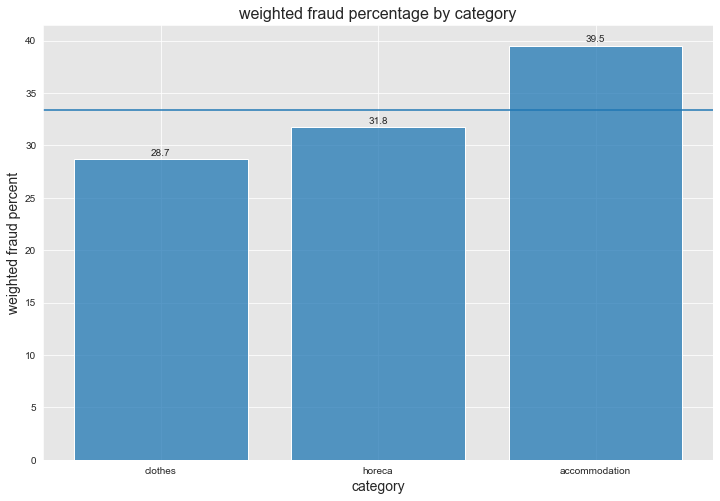

In [115]:
# plots fraud percentage by category;
ax = sns.histplot(
    df_agg_category,
    x='category',
    weights='weighted_fraud_contribution',
    shrink=0.8
)

ax.axhline(mean_category)
# sets the figure size in inches
ax.figure.set_size_inches(12, 8)

# set plot features
ax.set_title("weighted fraud percentage by category", fontsize=16)
ax.set_ylabel("weighted fraud percent", fontsize=14)
ax.set_xlabel("category", fontsize=14)

# displays plot
show_values(ax)

Looks like accomomdation category has the largest fraud rate. Could be because people book hotels online using stolen accounts.  
Let's look at a time series graph of fraud.

Text(0.5, 1.0, 'total number of fraud cases by month in 2019')

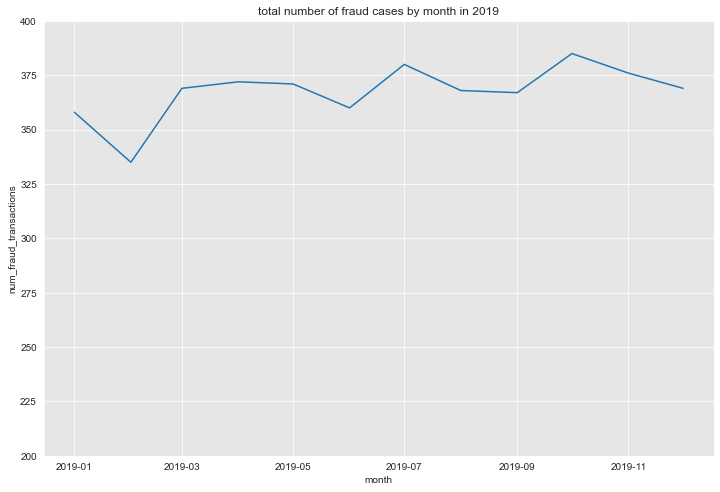

In [33]:
df_explore['month'] = df_explore['chck_date'].dt.to_period('M').dt.to_timestamp()
df_agg_month = df_explore.groupby(
   ['month']
).agg({   
         'fraud' : 'sum'    
}).reset_index()
df_agg_month.drop(df_agg_month.tail(1).index,inplace=True) 
df_agg_month.rename(columns={'fraud' : 'num_fraud_transactions'}, inplace=True)
# set figure size
plt.figure( figsize = ( 12, 8))
  
# plot a simple time series plot
# using seaborn.lineplot()
ax=sns.lineplot( x = 'month',
             y = 'num_fraud_transactions',
             data = df_agg_month)
ax.set(ylim=(200, 400))
ax.set_title("total number of fraud cases by month in 2019")

Total fraud cases are setady over month to montm.

## Feature engineering:

Assumptions:  

The dataset there are for fraud only contains the essential features that characterize a payment transaction. These are: a unique identifier for the transaction, the date and time of the transaction, the transaction amount, a unique identifier for the customer, a unique number for the merchant, and a binary variable that labels the transaction as legitimate or fraudulent.

Based on my interpretation of the dataset given, I have assumed that chck_date is the transaction date. It is possible that it could also mean something else like the date on which a manual checker evaluated the transaction for fraud. Also, in a real-life scenario it is important to have the transaction date to create features (described later in this notebook) that are important for fraud detection.  

Also, around 25% of the transactions do not have a chck _date. There are 2 ways to deal with this:  
    1. Ignore the transactions with no chck_date for the purposed of this exercise. Based on my approach of creating features for customer recency and merchant risk, I would have to generate random dates and assume that those are the transaction dates.  
    2. Treat the null chck_date data as test set with randomly generated dates as to fill the chck_date column. This complicates things as in a real life situation before modeling, I would ensure as far as possible that the transaction date is available.
    
 I will chose option for in the interest of time and for the reasons describved above.  
    

In this dataset, I will implement 4 types of features, i.e.  
1. time related features  
2. customer transaction behavior  
3. merchant risk  
4. categorical features based on sex, country and payment type  

In [34]:
data_df = data.loc[data['chck_date'].notna()]
# save as pickled file for later use
data_df.to_pickle("../data/df_ml.pkl")
data_df.head()

,transaction_id,batch,chck_date,customer,payment_type,gender,merchant,category,amount,fraud,country
3,252747,172,2019-03-10 02:22:00,8577606384,2,M,8176927312,transit,13.93,0,FR
5,169054,150,2019-09-16 13:58:00,179543699,3,M,14024986,food,83.76,0,NL
6,472320,114,2019-01-04 22:42:00,649373938,3,F,651065399,transit,32.51,0,DE
7,101476,32,2019-12-12 09:32:00,12537556,1,M,651065399,transit,48.05,0,GB
8,563904,41,2019-05-04 03:00:00,8284860,4,M,651065399,transit,20.47,0,DE


**1. Time and date features**  

(i). weekend features: create a feature indicating if the day of transaction is weekday or weekend  
(ii). night/day feature: indicates if transacton occured at night or day  

In [35]:
data_df['is_weekend']=data_df.chck_date.apply(is_weekend)

In [36]:
data_df['is_night']=data_df.chck_date.apply(is_night)

**2. Customer spending features**  

For customer realted features we will define the following:  
1. number of transactions that occur within a time window  
2. The second will be the average amount spent in these transactions  

The time windows will be set to one, seven, and thirty days. This will generate six new features. Note that these time windows could later be optimized along with the models using a model selection procedure. Also, since we assume that every transaction (fraud or not) during prediction will have a timestamp and we will have the amount of the transaction, THUS ELIMINATING THE POSSIBILITY OF DATA LEAKAGE during prediction.

In [37]:
data_df=data_df.groupby('customer').apply(lambda x: get_customer_rfm_features(x, windows_size_in_days=[1,7, 30]))
data_df=data_df.sort_values('chck_date').reset_index(drop=True)

**3. Merchant risk features**  

Here we extract a risk score, that assesses the exposure of a given terminal ID to fraudulent transactions. The risk score will be defined as the average number of fraudulent transactions that occurred on a terminal ID over a time window. As for customer ID transformations, we will use three window sizes, of 1, 7, and 30 days.

Contrary to customer ID transformations, the time windows will not directly precede a given transaction. Instead, they will be shifted back by a delay period. The delay period accounts for the fact that, in practice, the fraudulent transactions are only discovered after a fraud investigation or a customer complaint. Hence, the fraudulent labels, which are needed to compute the risk score, are only available after this delay period.For the purpose of this exercise, this delay period will be set to one week. As stated in the previous section, we assume that the timestamps of the transactions will be available during prediction, thus preventing DATA LEAKAGE.

In [38]:
data_df=data_df.groupby('merchant').apply(lambda x: get_count_risk_rolling_window(x, delay_period=7, windows_size_in_days=[1,7, 30], feature="merchant"))
data_df=data_df.sort_values('chck_date').reset_index(drop=True)

**4. Categorical features**

The following categorical columns will be label encoded:  
1. payment_type  
2. gender  
3. country  
4. category  


In [39]:
data_df = transform_cat_feats(data_df)

## Modeling and results  

The modeling process consists of 3 parts  
1. test/train split  
2. dealing with class imbalance  
3. grid search cv  

In [42]:
# check value counts of target variable
data_df.fraud.value_counts()

0    356728
1      4414
Name: fraud, dtype: int64

Since the fraud detection being positive is the minority class with only 1% of the data, we need to use some techniques to deal with this. Resampling strategies address class imbalance at the data level, by resampling the dataset to reduce the imbalance ratio. The resampling of an imbalanced dataset occurs before the training of the prediction model and can be seen as a data preprocessing step. There are numerous methods for resampling imbalanced datasets, but can be categorized into three main strategies: oversampling, undersampling, and hybrid strategies 

Oversampling consists in artificially increasing the proportion of samples from the minority class. The most naive approach is random oversampling (ROS), in which samples from the minority class are randomly duplicated. More sophisticated approaches consist in generating synthetic data by interpolating samples from the minority class. Two standard methods based on interpolation are SMOTE (Synthetic Minority Oversampling Technique)  and ADASYN (Adaptive Synthetic Sampling).

For this exericse we will use SMOTE, which is party of the imblearn pyhton library.


In [43]:
# drop these cols as they are not needed
cols_to_drop = ['transaction_id', 'batch', 'customer', 'merchant']
data_df.drop(cols_to_drop, inplace=True, axis=1)

In [45]:
data_df.columns

Index(['chck_date', 'payment_type', 'gender', 'category', 'amount', 'fraud',
       'country', 'is_weekend', 'is_night', 'customer_nb_tx1day_window',
       'customer_avg_amount_1day_window', 'customer_nb_tx7day_window',
       'customer_avg_amount_7day_window', 'customer_nb_tx30day_window',
       'customer_avg_amount_30day_window',
       'merchant_num_transactions_1day_window', 'merchant_risk_1day_window',
       'merchant_num_transactions_7day_window', 'merchant_risk_7day_window',
       'merchant_num_transactions_30day_window', 'merchant_risk_30day_window'],
      dtype='object')

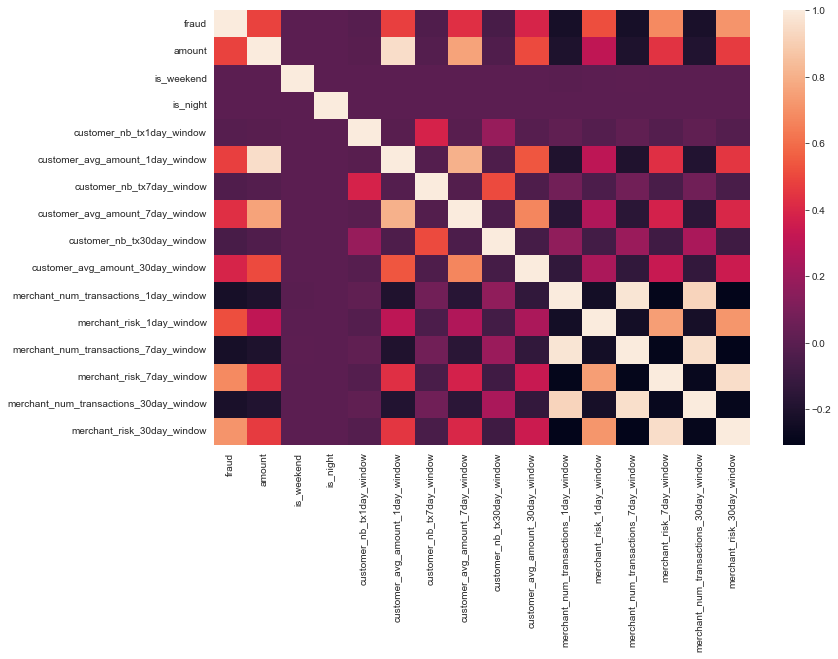

In [107]:
#make pairplots
var = ['fraud', 'amount', 'is_weekend', 'is_night', 'customer_nb_tx1day_window',
       'customer_avg_amount_1day_window', 'customer_nb_tx7day_window',
       'customer_avg_amount_7day_window', 'customer_nb_tx30day_window',
       'customer_avg_amount_30day_window',
       'merchant_num_transactions_1day_window', 'merchant_risk_1day_window',
       'merchant_num_transactions_7day_window', 'merchant_risk_7day_window',
       'merchant_num_transactions_30day_window', 'merchant_risk_30day_window']
#sns.corrplot(data_df, vars = var, dropna = True)
data_df1 = data_df[var]
sns.heatmap(data_df1.corr())
plt.show()